In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
from PIL import Image

import torchvision.datasets as dset
import torchvision.transforms as T
import chest_xray_code.data.xrays as preprocess_dataset
import chest_xray_code.data.raw_reports as utils
import os
import torch.nn.functional as F
from models.TestConvNet import TestConvNet



import numpy as np

In [9]:
class Data_SET(Dataset):
    """
    A customized data loader for MNIST.
    """
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        filenames = glob.glob(osp.join(root, '*.png'))
        i = 0
        for fn in filenames:
            #print('in loop',fn)
            self.filenames.append(fn) # (filename, label) pair
            i +=1
            if i == 500:
                break

        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        """
        Preload dataset to memory
        """
        self.labels = []
        self.images = []
        for image_fn in self.filenames:            
            # load images
            image = Image.open(image_fn)
            # avoid too many opened files bug
            self.images.append(image.copy())
            image.close()
            #self.labels.append(label)

    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]

        else:
            # If on-demand data loading
            image_fn = self.filenames[index]
            image = Image.open(image_fn)
            
        # May use transform function to transform samples
        # e.g., random crop, whitening
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image[:,100:300,100:300] #TODO: Train on 32x32 for practice, remove for final test

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len
    
trainset = Data_SET(
    root='chest_xray_code/data/xrays',
    preload=False, transform=transforms.ToTensor(),
)
# Use the torch dataloader to iterate through the dataset
trainset_loader = DataLoader(trainset, batch_size=20, shuffle=True, num_workers=32)

# load the testset
testset = Data_SET(
    root='chest_xray_code/data/test_set',
    preload=False, transform=transforms.ToTensor(),
)
#testset = trainset
# Use the torch dataloader to iterate through the dataset
testset_loader = DataLoader(testset, batch_size=15, shuffle=False, num_workers=1)

print(len(trainset))
print(len(testset))



500
0


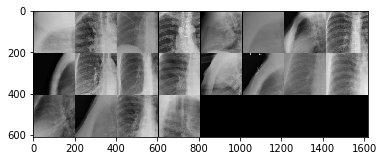

In [10]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    img = img.numpy()
    
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.savefig('compressed.png')
    
    # functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.savefig('original.png')

# get some random training images
dataiter = iter(trainset_loader)
images = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [11]:


transform = T.Compose([
                T.ToTensor()
                #T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

loader_train = trainset

images = {}

In [12]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    #dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 5


# Architecture

In [13]:
def train(model, epoch, log_interval=100):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    model = torch.nn.DataParallel(model)
    model.train()  # set training mode
    iteration = 0
    for ep in range(epoch):
        for batch_idx, (data) in enumerate(trainset_loader):
            data = data.to(device=device, dtype=dtype)
            optimizer.zero_grad()
            #print(data.shape)
            reconstruction = model(data)
            loss_function = nn.MSELoss(size_average=True)
            loss = loss_function(reconstruction, data)
            loss.backward()
            optimizer.step()
        if ep % print_every == 0:
            print('Iteration %d, loss = %.4f' % (ep, loss.item()))
            print()

def test():
    model.eval()  # set evaluation mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data in testset_loader:
            data = data.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(testset_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testset_loader.dataset),
        100. * correct / len(testset_loader.dataset)))

    

In [14]:
channels = 3
size = 32
model = TestConvNet(channels,size)
model.to(device)


optimizer = optim.Adam(model.parameters(), lr=5e-3) 
#train(model,20)
#torch.save(model, 'something_else.pt')

Visualize the Compressed images 

/home/shared/anaconda3/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'models.TestConvNet.TestConvNet' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


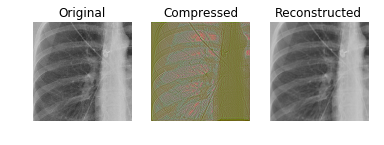

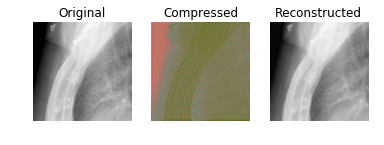

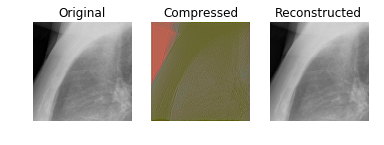

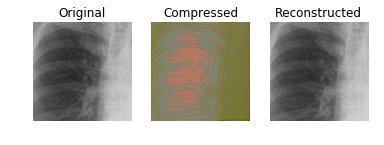

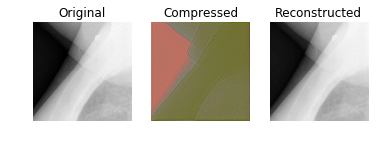

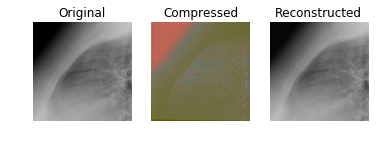

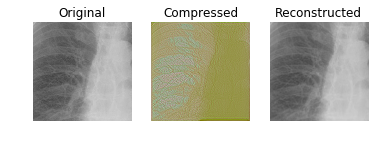

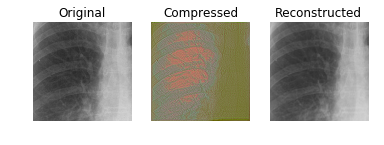

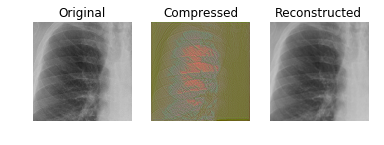

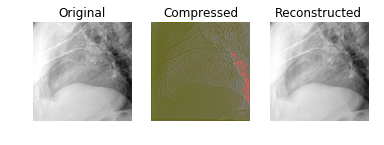

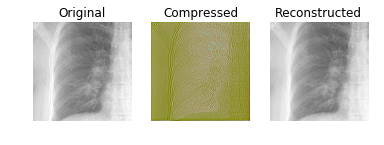

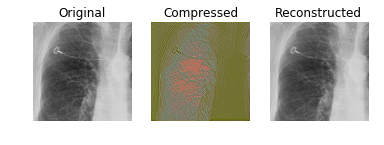

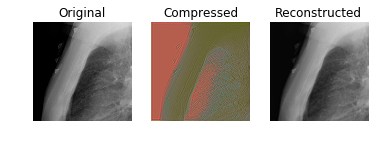

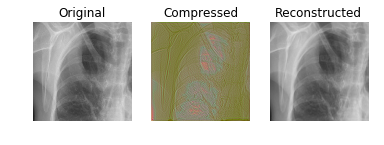

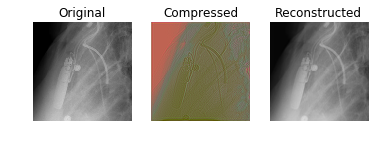

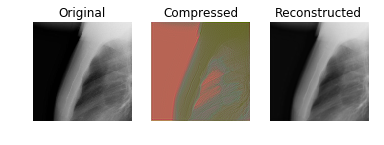

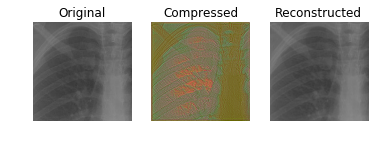

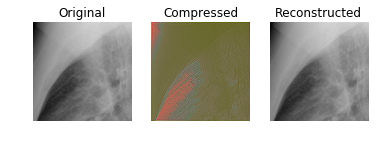

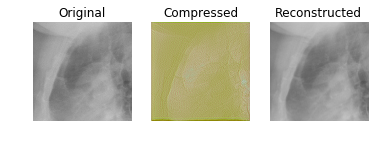

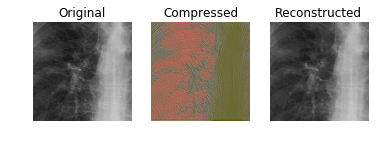

In [15]:


model = torch.load('trained_models/xraymodelV2.pt')

plt.close("all")


images = [[],[]]

def prep(img):
    img = img.numpy()
    if True:
        img_max, img_min = np.max(img), np.min(img)
        img = .8 * (img - img_min) / (img_max - img_min)
    return np.transpose(img, (1, 2, 0))
    
def save_compressed(self,input,output):
    #for i in range(1):
    img = output.cpu().detach()
    for i in range(img.shape[0]):
        individual_img = img[i]
        images[1].append(prep(individual_img))
    
    
        
        

def save_original(data):
    img = data.cpu().detach()
    
    for i in range(img.shape[0]):
        individual_img = img[i]
        individual_img = individual_img.numpy()
        individual_img = np.transpose(individual_img, (1, 2, 0))
        images[0].append(individual_img)

hook = model.conv_compress_final.register_forward_hook(save_compressed)
#hook.remove()
        
        
i = 0
reconstruction = None
for data in trainset_loader:
    with torch.no_grad():
        if i > 0: break
        data = data.to(device)
        save_original(data)
        reconstruction = model(data)
        i+=1

for i in range(20):
    plt.figure()
    org = images[0][i]
    plt.subplot(1, 3, 1)
    plt.axis('off')
    #imshow_noax(org, normalize=False)
    plt.imshow(org)
    plt.title('Original')
    plt.subplot(1, 3, 2)
    rec = images[1][i]
    plt.imshow(rec)
    #imshow_noax(rec, normalize=False)
    plt.title('Compressed')
    plt.axis('off')
    image_str = str(i) + ".png"
    plt.subplot(1, 3, 3)
    plt.axis('off')
    rec = imshow(reconstruction[i].cpu().detach())
    plt.title('Reconstructed')
    plt.show()


Visualize the Reconstructed Images

In [ ]:
for i in range(20):
    plt.figure()
    org = originals[i].cpu().detach().numpy().transpose(1,2,0)
    org = np.maximum(org,1)
    org = np.minimum(org,0)
    plt.subplot(1, 2, 1)
    imshow_noax(org, normalize=False)
    plt.title('Original image')
    plt.subplot(1, 2, 2)
    rec = reconstruction[i].cpu().detach().numpy().transpose(1,2,0)
    rec = np.maximum(rec,1)
    rec = np.minimum(rec,0)
    imshow_noax(rec, normalize=False)
    plt.title('Reconstructed image')
    plt.show()

